I will be building a segmentation model of InstaCart users to then use the segment as a factor to basic classifier model that predicts their next order. Another way to put is that identifying products that are likely to be purchased by the same user.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

I shall get the required data with their respective order_id,product_id and user_id as the respected index columns

In [2]:
orders = pd.read_csv("Data/orders.csv",usecols=['order_id','user_id','eval_set'],index_col="order_id")
orders.head()

/home/dark/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,user_id,eval_set
order_id,,
2539329,1,prior
2398795,1,prior
473747,1,prior
2254736,1,prior
431534,1,prior


In [3]:
print(f"Total no.of users: {len(orders['user_id'])}")
print(f"no.of Unique Users: {len(orders['user_id'].unique())}")

Total no.of users: 3421083
no.of Unique Users: 206209


In [4]:
products = pd.read_csv("Data/products.csv",index_col="product_id")
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [5]:
items_prior = pd.read_csv("Data/order_products__prior.csv",usecols=['order_id','product_id'],index_col=['order_id',"product_id"])
items_prior.head()

/home/dark/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Empty DataFrame
Columns: []
Index: [(2, 33120), (2, 28985), (2, 9327), (2, 45918), (2, 30035)]

In [6]:
user_product = orders.join(items_prior,how="inner").reset_index().groupby(['user_id','product_id']).count()
user_product = user_product.reset_index().rename(columns={'order_id':"prior_order_count"})
user_product.head()

,user_id,product_id,prior_order_count,eval_set
0,1,196,10,10
1,1,10258,9,9
2,1,10326,1,1
3,1,12427,10,10
4,1,13032,3,3


the above data shows us which customers have bought which products, getting the exact data we need to build up a recommendation

In [8]:
from scipy.sparse import csr_matrix
user_product_sparse = csr_matrix((user_product['prior_order_count'], (user_product['user_id'], user_product['product_id'])), shape=(user_product['user_id'].max()+1, user_product['product_id'].max()+1), dtype=np.uint16)
print(user_product_sparse.shape)

(206210, 49689)


Since the data is huge, we may face the "curse of dimensionality" problem, So I've decided to reduce the dimensionality with singular value decomposition algorithm.

First I shall create a compressed sparse row matrix for the SVD algorithm to be applied.

In [9]:
from sklearn.decomposition import TruncatedSVD
decomp = TruncatedSVD(n_components=10,random_state=1)
user_reduced = decomp.fit_transform(user_product_sparse)
print(decomp.explained_variance_ratio_[:10],decomp.explained_variance_ratio_.sum())

[0.06062681 0.03188183 0.01226987 0.00988537 0.00946229 0.00768103
 0.00719953 0.00654459 0.0064038  0.0054756 ] 0.15743072048254989


As expected we can tell that the data which had ~49k data points has been reduced to 10 components. In short we have extracted the most variance from the data and reduced to 10 key points with 15.74% of total variance and important factor which explains 6% of the variance. (Not bad for a compression like this)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_reduced_scaled = scaler.fit_transform(user_reduced)

We don't want to deal with high continous values (model may underfit) leading to bad predictions, so we use standard scaler which removes the mean and scales each variable to unit variance, punishing high values.

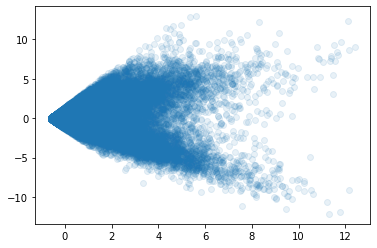

In [11]:
plt.scatter(user_reduced_scaled[:,0],user_reduced_scaled[:,1],alpha=0.1)

In [13]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.05, random_state=1)
clf.fit(user_reduced_scaled)
outliers = clf.predict(user_reduced_scaled)

unique, counts = np.unique(outliers, return_counts=True)
dict(zip(unique, counts))

{-1: 10311, 1: 195899}

It's a good idea to get rid of outliers before clusterization by then we don't have to deal with getting separate classes and the rest to one class.
I've used Isolationforest with 5% set as the share of outliers to be excluded at the step of applying Kmeans.

In [21]:
from sklearn.cluster import KMeans

clusters_count = 10

kmc = KMeans(n_clusters=clusters_count, init='random', n_init=10, random_state=101)
kmc.fit(user_reduced_scaled[outliers == 1,:])
clusters = kmc.predict(user_reduced_scaled)

unique, counts = np.unique(clusters, return_counts=True)
dict(zip(unique, counts))

{0: 4394,
 1: 9828,
 2: 8235,
 3: 7985,
 4: 6586,
 5: 6330,
 6: 7101,
 7: 7029,
 8: 4453,
 9: 144269}

As we can tell from the model, vast amount of users are at one class, which is not very good but it's okay in the real world where users tend to fall in a similar category.

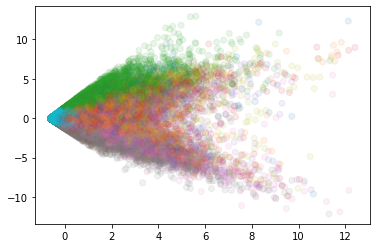

In [22]:
plt.scatter(user_reduced_scaled[:,0],user_reduced_scaled[:,1],c=clusters/(clusters_count-1),cmap="tab10",alpha=0.1)

The graph looks not bad but still is a mess, Remembering that I've used 10 cluster points I can't really complain.

In [23]:
top_products_overall = user_product[['product_id','prior_order_count']].groupby('product_id').sum().reset_index().sort_values('prior_order_count', ascending=False)
top_products_overall['rank_overall'] = top_products_overall['prior_order_count'].rank(ascending=False)

usersdf = pd.DataFrame(clusters[1:], columns=['cluster'], index=np.arange(1, user_product['user_id'].max()+1))

In [24]:
top_products = user_product.merge(usersdf, left_on='user_id', right_index=True)[['product_id','cluster','prior_order_count']].groupby(['product_id','cluster']).sum().reset_index().sort_values(['cluster','prior_order_count'], ascending=False)
top_products['rank'] = top_products[['cluster','prior_order_count']].groupby('cluster').rank(ascending=False)


top_products = top_products.merge(top_products_overall[['product_id','rank_overall']], left_on='product_id', right_on='product_id')

top_products['rank_diff'] = top_products['rank'] - top_products['rank_overall']

top_products_asc_diff = top_products.sort_values(['cluster','rank_diff'], ascending=False).groupby('cluster').head(2).reset_index(drop=True)
top_products_desc_diff = top_products.sort_values(['cluster','rank_diff'], ascending=True).groupby('cluster').head(2).reset_index(drop=True)
top_products_diff = pd.concat([top_products_asc_diff,top_products_desc_diff], axis=0)


In [26]:
top_prods = top_products_diff.merge(products[['product_name']], left_on='product_id', right_index=True)[['cluster','product_name','rank','rank_overall','rank_diff']].sort_values(['cluster','rank_diff'])
top_prods.head()

,cluster,product_name,rank,rank_overall,rank_diff
0,0,Real Coco 100% Organic Coconut Water,15646.5,47062.5,-31416.0
1,0,"Herbal Tea, Lemon Ginger, Caffeine-Free, Bags",18786.0,48902.0,-30116.0
19,0,Pub Mix,25792.0,1308.0,24484.0
18,0,Sweet Kale Salad Mix,25792.0,410.0,25382.0
2,1,3rd Foods Mixed Vegetables & Beef Dinner,20133.5,44912.5,-24779.0


As the output predicted, We have successfully segmented each customer to 10 different groups, Some of the clusters doesn't really make any sense but still the KMeans have done a great job by clustering customers into 10 different categories, There is no way of predicting the reality. People change, their preferences changes. Marketing campaigns can work according to the segmentation and later the model can be tuned to way which both the customers and the campigns are satisfied.